In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras import optimizers
from tensorflow_examples.models.pix2pix import pix2pix
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


/home/mimus/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
import os


input_dir = "/home/mimus/apifave/images/saved_masks/reneameds/train/train_images/"
target_dir = "/home/mimus/apifave/images/saved_masks/reneameds/train/train_segmentation/"
img_size = (112, 208)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 5561
/home/mimus/apifave/images/saved_masks/reneameds/train/train_images/original_0_0_3.jpg | /home/mimus/apifave/images/saved_masks/reneameds/train/train_segmentation/masks_0_0_3.jpg
/home/mimus/apifave/images/saved_masks/reneameds/train/train_images/original_0_10.jpg | /home/mimus/apifave/images/saved_masks/reneameds/train/train_segmentation/masks_0_10.jpg
/home/mimus/apifave/images/saved_masks/reneameds/train/train_images/original_0_11.jpg | /home/mimus/apifave/images/saved_masks/reneameds/train/train_segmentation/masks_0_11.jpg
/home/mimus/apifave/images/saved_masks/reneameds/train/train_images/original_0_12.jpg | /home/mimus/apifave/images/saved_masks/reneameds/train/train_segmentation/masks_0_12.jpg
/home/mimus/apifave/images/saved_masks/reneameds/train/train_images/original_0_13.jpg | /home/mimus/apifave/images/saved_masks/reneameds/train/train_segmentation/masks_0_13.jpg
/home/mimus/apifave/images/saved_masks/reneameds/train/train_images/original_0_14.jpg | /

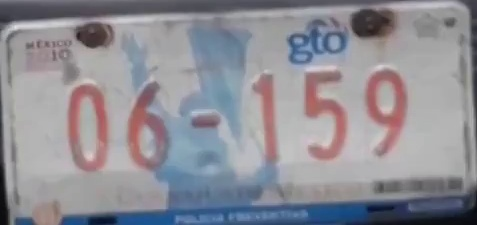

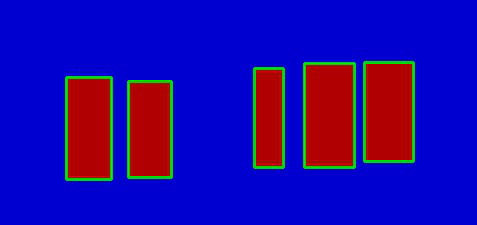

In [3]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [4]:
from tensorflow import keras
import numpy as np



class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            
            
            
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="rgb")
            
            
            
            y[j] = img
        return x, y
    

In [5]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)

In [6]:
import random

# Split our img paths into a training and a validation set
val_samples = 800
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)



In [10]:


# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(loss="categorical_crossentropy",  optimizer=optimizers.RMSprop(lr=5e-5), metrics=['acc'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model_history= model.fit(train_gen, epochs=epochs, validation_data=val_gen)



Epoch 1/30
148/148 [==============================] - 27s 183ms/step - loss: 13.4833 - acc: 0.9816 - val_loss: 14.7095 - val_acc: 0.9749
Epoch 2/30
148/148 [==============================] - 27s 181ms/step - loss: 13.3742 - acc: 0.9822 - val_loss: 14.5689 - val_acc: 0.9754
Epoch 3/30
148/148 [==============================] - 27s 181ms/step - loss: 13.3192 - acc: 0.9825 - val_loss: 14.7718 - val_acc: 0.9748
Epoch 4/30
148/148 [==============================] - 27s 180ms/step - loss: 13.2545 - acc: 0.9829 - val_loss: 14.5257 - val_acc: 0.9760
Epoch 5/30
148/148 [==============================] - 27s 180ms/step - loss: 13.1969 - acc: 0.9831 - val_loss: 14.4816 - val_acc: 0.9760
Epoch 6/30
148/148 [==============================] - 27s 180ms/step - loss: 13.1315 - acc: 0.9836 - val_loss: 14.3373 - val_acc: 0.9768
Epoch 7/30
148/148 [==============================] - 27s 181ms/step - loss: 13.0763 - acc: 0.9839 - val_loss: 14.4044 - val_acc: 0.9765
Epoch 8/30
148/148 [=====================

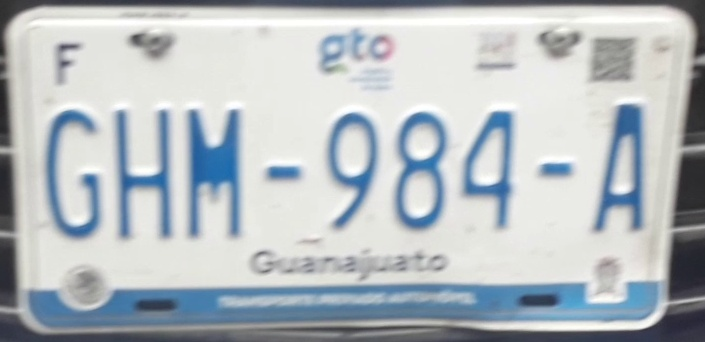

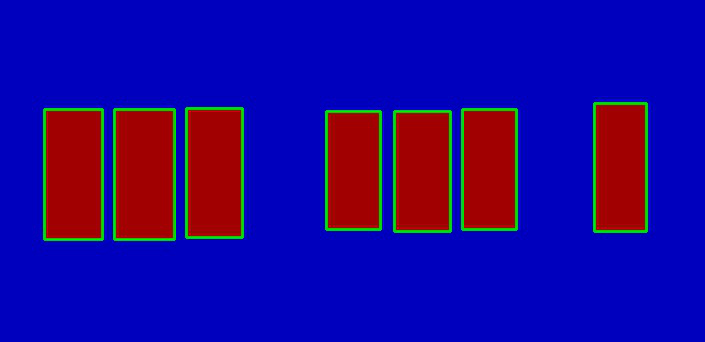

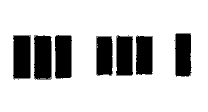

In [8]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

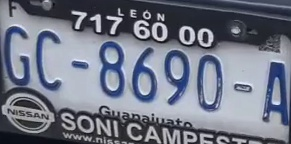

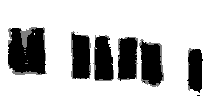

In [9]:
path = "/home/mimus/apifave/images/saved_masks/meee/for test/original_6.jpg"
img = load_img(path, target_size=(112,208), color_mode="rgb")
img = tf.keras.preprocessing.image.img_to_array(img)


val_preds = model.predict(img[tf.newaxis, ...])


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    
    display(img)
    img = img.save("mask.jpg") 
display(Image(filename=path))
display_mask(0)    

In [10]:
model.save('char_seg_plate_v9771_rgb.h5')